<a href="https://colab.research.google.com/github/marcoplacenti/protein_generation/blob/main/final/redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [291]:
from google.colab import drive
import torch, sys
import pandas as pd
import numpy as np  
from torch import nn
import torch.nn.functional as F
from torchtext import data
import torch.distributions as dist
import random
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [292]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [293]:
cd /content/drive/MyDrive/'Colab Notebooks'/project/

/content/drive/MyDrive/Colab Notebooks/project


In [433]:
def process_data(data, vocab, max_seq):
    token_to_id, id_to_token = {}, {}
    
    token_to_id["<PAD>"] = 0
    id_to_token[0] = "<PAD>"

    token_to_id["<EOS>"] = 1
    id_to_token[1] = "<EOS>"

    token_to_id["<DUMMY>"] = 2
    id_to_token[2] = "<DUMMY>"

    for i, token in enumerate(vocab):
        cum_i = len(token_to_id.keys())
        if token != "<PAD>" and token != "<EOS>" and token != "<DUMMY>":
            token_to_id[token] = cum_i
            id_to_token[cum_i] = token
            cum_i += 1

    seq = []
    for record in data.values:
        tags = record[:-1]
        sequence = record[-1]
        
        encoded_record = [token_to_id[tag] for tag in tags]

        for char in sequence:
            encoded_record.append(token_to_id[char])
        #encoded_record.append(token_to_id["<EOS>"])
        
        if len(sequence) < max_seq:
            for i in range(max_seq-len(sequence)):
                encoded_record.append(token_to_id["<PAD>"])

        seq.append(encoded_record)

    return np.array(seq), token_to_id, id_to_token

In [295]:
def get_data(dataset):
    data = pd.read_csv(dataset)

    data = data.replace(np.nan, '<DUMMY>', regex=True)
    #data.drop("Unnamed: 0", axis=1, inplace=True)
    #data.drop("Entry", axis=1, inplace=True)
    #print(data.columns)
    max_length = int(data['Sequence'].str.len().max())
    data = data[data["Sequence"].map(len) <= max_length]
    vocab = set()
    for col in data.columns:
        if col != "Sequence":
            vocab.update(data[col])

    seq_len = []
    max_seq = 0
    for seq in data["Sequence"]:
        seq = [s for s in seq]
        seq_len.append(len(seq))
        if len(seq) > max_seq:
            max_seq = len(seq)
        vocab.update(seq)

    vocab.update(["<PAD>"])
    vocab.update(["<EOS>"])

    return data, vocab, max_seq

In [477]:
class ProGen(nn.Module):
  
  def __init__(self, hid_size, vocab_size, n_head, n_layers, pf_size, max_len, device):
    super().__init__()

    self.device = device
    self.hid_size = hid_size
    self.pf_size = pf_size
    self.max_len = max_len
    self.embedding = nn.Embedding(vocab_size, hid_size)
    self.position_enc = nn.Embedding(self.max_len, self.hid_size)
    self.position_enc.weight.data = self.position_encoding_init(self.max_len, self.hid_size)
    self.scale = torch.sqrt(torch.FloatTensor([self.hid_size])).to(device)

    self.layer_norm = nn.LayerNorm(self.hid_size)
    self.decoder_layer = nn.TransformerDecoderLayer(d_model=hid_size, nhead = n_head, dim_feedforward=self.pf_size)
    self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=n_layers, norm=self.layer_norm)
    self.fc = nn.Linear(hid_size, vocab_size)
    self._init_weights()
  
  def forward(self, x):
    sent_len, batch_size = x.shape[0], x.shape[1]
    memory_mask = self.generate_complete_mask(sent_len)
    tgt_mask = self.generate_triangular_mask(sent_len)
    memory = torch.zeros(1, batch_size, self.hid_size, device=self.device)

    temp = x
    temp = self.embedding(temp)

    pos = torch.arange(0,sent_len).unsqueeze(1).repeat(1,batch_size).to(self.device)
    temp_pos_emb = self.position_enc(pos)

    temp = temp * self.scale + temp_pos_emb
    temp = self.decoder(temp, memory, tgt_mask=tgt_mask)
    temp = self.fc(temp)
    return temp

  def _init_weights(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)

  def append_decoder_layer(self):
    appended_mod = nn.TransformerDecoderLayer(d_model=hid_size, nhead = n_head).to(self.device)
    for p in appended_mod.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    model.decoder.layers.append(appended_mod)
    model.decoder.num_layers += 1

  def generate_triangular_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
        return
        
  def generate_complete_mask(self, size):
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        mask = torch.empty(size, size).to(device)
        mask.fill_(float('-inf'))
        return mask

  def generate_sequence(self, src):
    #src = [sent_len]
    src = src.unsqueeze(1)
    #src = [sent_len, 1]
    generate_step = 0
    while generate_step < 120:
      out = self.forward(src)
      #out = [sent_len + 1, 1, vocab_size]
      out = torch.argmax(out[-1, :], dim=1) # [1]
      out = out.unsqueeze(0) #[1,1]
      src = torch.cat((src, out), dim=0)
      generate_step += 1
    src = src.squeeze(1)
    return src
  
  def position_encoding_init(self, n_position, d_pos_vec):
    ''' Init the sinusoid position encoding table '''

    # keep dim 0 for padding token position encoding zero vector
    position_enc = np.array([
        [pos / np.power(10000, 2*i/d_pos_vec) for i in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    temp = torch.from_numpy(position_enc).type(torch.FloatTensor)
    temp = temp.to(self.device)
    return temp

In [297]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [511]:
file = "dataset.csv"

data, vocab, max_seq = get_data(file)
seq, token_to_id, id_to_token = process_data(data, vocab, max_seq)

In [512]:
vocab_size = len(vocab)
hid_size = 32
pf_size = 16
max_len = 120
n_head = 4
n_layer= 8
model = ProGen(hid_size, vocab_size, n_head, n_layer, pf_size, max_len, device).to(device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 161,122 trainable parameters


In [513]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [514]:
seq=torch.from_numpy(seq)

In [515]:
stats = { 'epoch':[], 'train_loss': [], 'train_perplexity': [], 'test_loss': [], 'test_perplexity': [] }
batch_size, epochs, clip = 16, 200, 500

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss()

for i in range(epochs):
  data, targets = get_batch(seq, i)
  optimizer.zero_grad()
  output = model(data)
  loss = criterion(output.view(-1, len(vocab)), targets)
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
  optimizer.step()
  total_loss += loss.item()
  stats['epoch'].append(i)
  stats['train_loss'].append(loss.item())
  print(i,loss.item())

0 6.92336368560791
1 6.520681381225586
2 6.175286293029785
3 5.58915376663208
4 5.158373832702637
5 4.71899938583374
6 4.32014274597168
7 3.9640698432922363
8 3.6690785884857178
9 3.4386723041534424
10 3.274474859237671
11 3.1297178268432617
12 3.0211434364318848
13 2.9239602088928223
14 2.8185536861419678
15 2.771613359451294
16 2.645995855331421
17 2.5627923011779785
18 2.4827709197998047
19 2.4133098125457764
20 2.3507657051086426
21 2.297030448913574
22 2.241499662399292
23 2.2194409370422363
24 2.181461811065674
25 2.1490275859832764
26 2.1196694374084473
27 2.6490957736968994
28 2.134941339492798
29 2.0950958728790283
30 2.0725433826446533
31 1.9920423030853271
32 2.0792548656463623
33 2.231052875518799
34 2.00692081451416
35 2.144277572631836
36 2.1300559043884277
37 2.0969722270965576
38 2.0286571979522705
39 1.952775478363037
40 1.9602395296096802
41 1.9524412155151367
42 2.0717320442199707
43 2.0689001083374023
44 2.069622278213501
45 2.11448073387146
46 2.004620313644409
47 

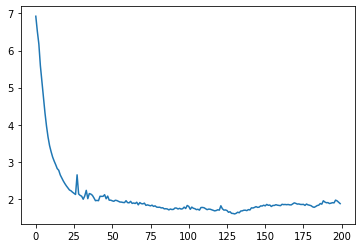

In [516]:
import matplotlib.pyplot as plt
plt.plot(stats['epoch'], stats['train_loss'])
plt.show()

In [475]:
test_x[1,50:]

tensor([  2,   2,   2,   2,   2,   2,   2,   2,   2,   2, 492, 426, 426, 832,
        607, 671, 144, 174, 933, 426, 607, 426,  84, 607, 426, 607,  45, 426,
        607, 426,  45, 607, 164, 933, 607,  84,  40,  84, 806, 144, 144, 671,
        144, 551, 956, 144, 164, 551,  40,  84, 144, 144, 551, 551, 607,  84,
        671, 806, 806, 933,  84, 607, 100,  28, 806, 832, 956, 607, 832, 933,
        100, 475, 100, 806, 164, 671, 100, 901,  84, 475, 551,  40, 426, 426,
         84, 551, 607, 607, 572, 164, 164,  40, 956, 956, 100,  40, 475, 100,
        901, 100, 806,  40,  40, 901, 806, 492, 174,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0])